In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('База Пермь.xlsx')
data.head()

,call_id,client_id,employee_id,offer_type,offer_time_sec,voice_offer_flag,application_flag,utilization_flag,utilization_dt,client_agree_flg,...,foreign_flg,suppress_call_flg,suppress_email_flg,suppress_limit_flg,suppress_sms_flg,work_experience_day_cnt,employee_type,employee_city,employee_gender,business_line
0,c79272292fb4da61073f3948c91243a6,2c9a3f43e84fe978413591e3d2cfbb47,17fbc7a11e9791cfa3c8794766f91a62,Кредитная карта,NaN,0,0,0,NaN,NaN,...,0,0.0,0.0,NaN,NaN,176,ТК,Ростов-на-Дону,Женщина,Депозитные продукты
1,756cebcf56702596e720743aa9dbf2ad,09d2c607e767465feeadc967f900d02e,94ee713355b04da08a7ad09dcfb1fa3d,Кредитная карта,NaN,0,0,0,NaN,NaN,...,0,0.0,0.0,NaN,0.0,1754,ГПД,г Калуга,Мужчина,Депозитные продукты
2,9cf572e8edb87a9bc5ae0be324e6659d,91beab05ed863ab7777450e2c9621465,6422a9613dd04d51537e6ceb38352586,Кредитная карта,NaN,0,0,0,NaN,NaN,...,0,0.0,0.0,NaN,NaN,301,ПКЦ,Энгельс г,Женщина,Депозитные продукты
3,95631b3755d9e1e5b4dfb2168223aaa6,ceecfb6ce0ff8dda5af4077768bbdfda,6ceb678f204a96c4b9506c2556567b14,Кредитная карта,NaN,0,0,0,NaN,NaN,...,0,0.0,0.0,NaN,NaN,622,ТК,NaN,Мужчина,Экосистемные обращения
4,82c5af9f8d5450f902c8b90b02529f0a,23c841702bb5fc589774d78f6a352159,09d17b542218ca16c2dac7eff23205a1,Дебетовая карта,NaN,0,0,0,NaN,NaN,...,0,0.0,0.0,NaN,NaN,94,ТК,NaN,Женщина,Депозитные продукты


In [3]:
data.shape

(150000, 36)

## preprocessing

In [4]:
df = data.copy()

In [5]:
df = df.drop_duplicates(subset=['call_id'])

In [6]:
df['pitching_time_part'] = df['offer_time_sec'] / df['employee_dialog_time_sec']
df['pitching_time_part_group'] = pd.qcut(df['pitching_time_part'], q=4, labels=['low', 'medium', 'high', 'very high'])

In [54]:
# Фильтруем данные с озвученными предложениями
df_voice = df[df['voice_offer_flag'] == 1].copy()

# Группируем по операторам и создаем целевую переменную - отношение времени к заявкам
operator_conversion = df_voice.groupby('employee_id').agg({
    'employee_dialog_time_sec': 'sum',
    'application_flag': 'sum'
}).reset_index()

# Вычисляем целевую переменную (избегаем деления на ноль)
operator_conversion['time_per_application'] = (
    operator_conversion['employee_dialog_time_sec'] / 
    operator_conversion['application_flag'].replace(0, np.nan)
)

# Удаляем промежуточные столбцы (если нужно)
operator_conversion.drop(['employee_dialog_time_sec', 'application_flag'], axis=1, inplace=True)

# Далее добавляем остальные признаки как в вашем исходном коде...
constant_features = [
    'work_experience_day_cnt', 
    'employee_type', 
    'employee_city', 
    'employee_gender', 
    'business_line'
]

for feature in constant_features:
    operator_data = df_voice.groupby('employee_id')[feature].first().reset_index()
    operator_conversion = operator_conversion.merge(operator_data, on='employee_id')

# variable_aggregations = {
#     'wait_time_sec': ['mean', 'median'],
#     'repeated_appeal_flg': 'mean',
#     'negative_flg': 'mean',
#     'transfer_flg': 'mean',
#     'task_flg': 'mean'
# }

variable_aggregations = {
    'offer_time_sec': ['mean', 'median', 'std'],
    'wait_time_sec': ['mean', 'median'],
    'appeal_time_sec': ['mean', 'median'],
    'employee_dialog_time_sec': ['mean', 'median'],
    'repeated_appeal_flg': 'mean',
    'negative_flg': 'mean',
    'csat_score': 'mean',
    'transfer_flg': 'mean',
    'task_flg': 'mean',
    'client_age': ['mean', 'std'],
    # 'client_agree_flg': 'mean'
}

for col, aggs in variable_aggregations.items():
    agg_df = df_voice.groupby('employee_id')[col].agg(aggs).reset_index()
    agg_df.columns = ['employee_id'] + [f'{col}_{a}' for a in (aggs if isinstance(aggs, list) else [aggs])]
    operator_conversion = operator_conversion.merge(agg_df, on='employee_id')

operator_conversion = operator_conversion.dropna()

In [ ]:
from catboost import CatBoostRegressor

# Подготовка данных
X = operator_conversion.drop(['employee_id', 'time_per_application'], axis=1, inplace=False)
y = operator_conversion['time_per_application']

# Определяем категориальные признаки
cat_features = ['employee_type', 'employee_city', 'employee_gender', 'business_line']

# Обучаем модель
model = CatBoostRegressor(verbose=2, random_state=42, iterations=1000, depth=4)
model.fit(X, y, cat_features=cat_features)

Learning rate set to 0.040565
0:	learn: 2679.9368950	total: 2.46ms	remaining: 2.46s
2:	learn: 2645.0084186	total: 5.54ms	remaining: 1.84s
4:	learn: 2608.2479964	total: 6.85ms	remaining: 1.36s
6:	learn: 2578.8251342	total: 7.98ms	remaining: 1.13s
8:	learn: 2549.2379961	total: 8.93ms	remaining: 983ms
10:	learn: 2522.9226024	total: 9.98ms	remaining: 898ms
12:	learn: 2500.5882363	total: 11ms	remaining: 835ms
14:	learn: 2476.4078997	total: 12.4ms	remaining: 816ms
16:	learn: 2458.7744866	total: 13.6ms	remaining: 786ms
18:	learn: 2437.4698441	total: 15.2ms	remaining: 787ms
20:	learn: 2416.5604477	total: 16.6ms	remaining: 773ms
22:	learn: 2399.0994836	total: 17.9ms	remaining: 761ms
24:	learn: 2383.8735783	total: 19.5ms	remaining: 762ms
26:	learn: 2370.7313416	total: 21ms	remaining: 757ms
28:	learn: 2360.4229723	total: 22.3ms	remaining: 747ms
30:	learn: 2350.4269282	total: 23.4ms	remaining: 731ms
32:	learn: 2341.2485672	total: 25.5ms	remaining: 746ms
34:	learn: 2328.5550016	total: 26.6ms	remain

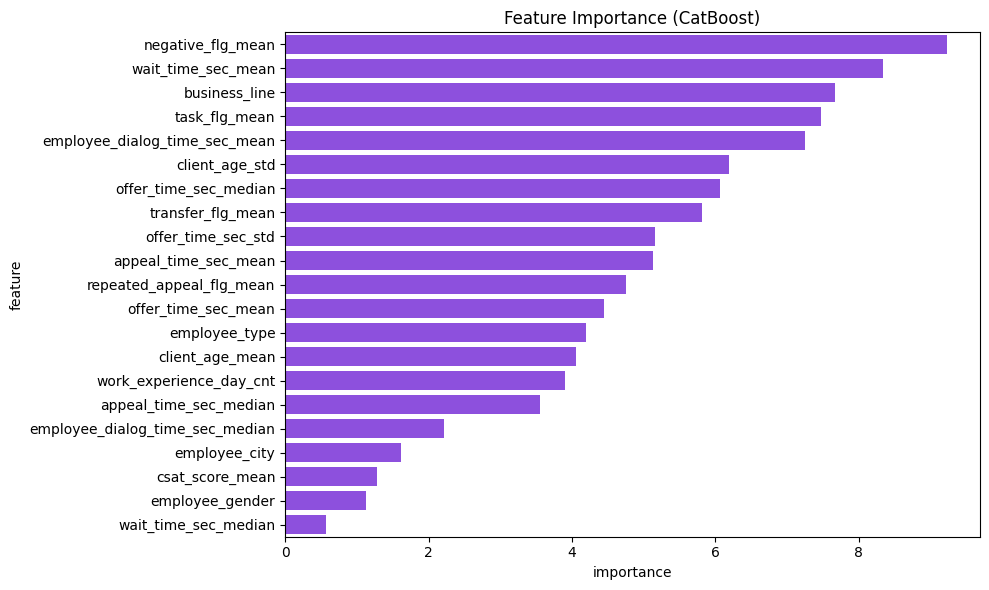

In [56]:
# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, color="#8A38F5")
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()

<Axes: xlabel='work_experience_day_cnt', ylabel='time_per_application'>

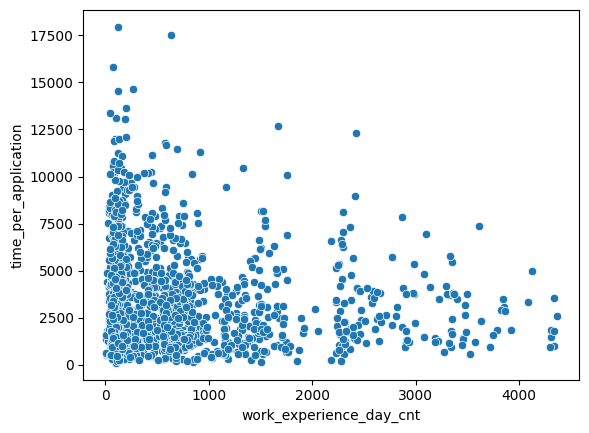

In [50]:
sns.scatterplot(x=operator_conversion['work_experience_day_cnt'], y=operator_conversion['time_per_application'])